In [14]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import torch
import pickle
import pandas as pd
from scipy.ndimage import uniform_filter1d
from sklearn.mixture import GaussianMixture

In [2]:
SUBJECTS = ["Yuri", "Tina"]
space = []
for S in SUBJECTS:
    if S in ["Yuri", "Tina"]:
        space.append("TY")
    elif S in ["Sally", "Buzz"]:
        space.append("SB")
subject_space = list(zip(SUBJECTS, space))

[0 1 2 3]
[0 1 2 3]


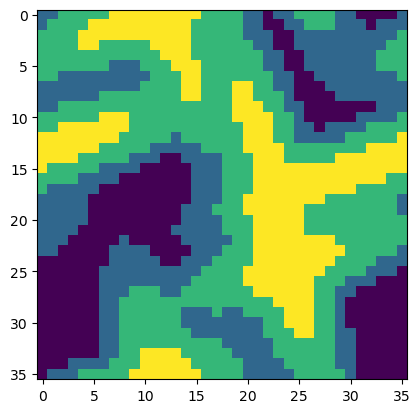

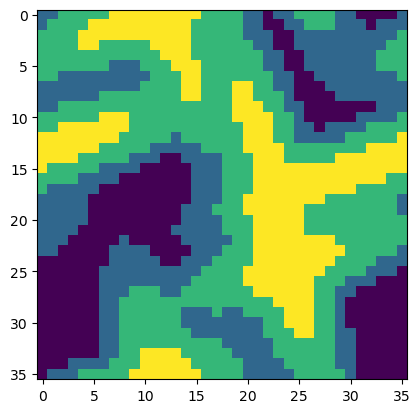

In [3]:
for _, space in subject_space:
    fig, ax = plt.subplots()
    reward_map = pd.read_csv("../../data/reward_space_" + space + ".csv").iloc[:, 0].values.reshape((36, 36)).T
    ax.imshow(reward_map)
    fig.savefig("../saved_data/out_rl_figs/reward_map_" + space + ".svg")
    print(np.unique(reward_map))

[2.1064e-05 2.1222e-05 2.1482e-05 ... 2.4456e-03 2.4491e-03 2.4639e-03]
[2.1064e-05 2.1222e-05 2.1482e-05 ... 2.4456e-03 2.4491e-03 2.4639e-03]


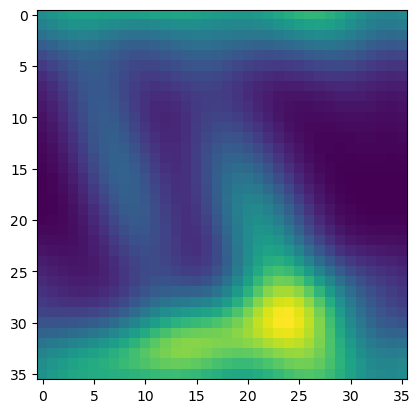

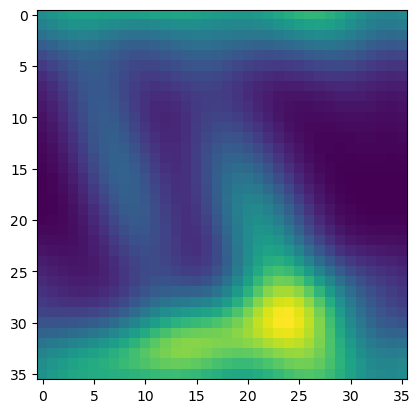

In [4]:
for _, space in subject_space:
    fig, ax = plt.subplots()
    fmap = pd.read_csv("../../data/freq_space_" + space + ".csv").iloc[:, 0].values.reshape((36, 36)).T
    ax.imshow(fmap)
    fig.savefig("../saved_data/out_rl_figs/freq_map_" + space + ".svg")
    print(np.unique(fmap))

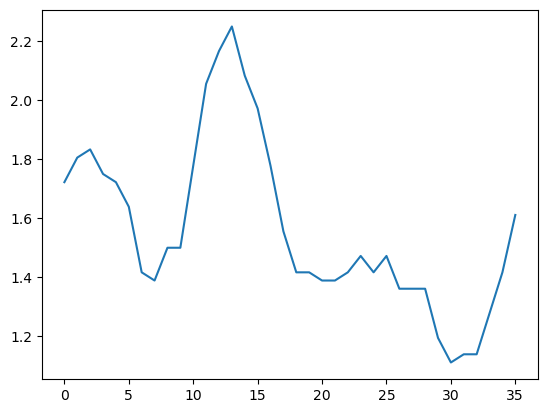

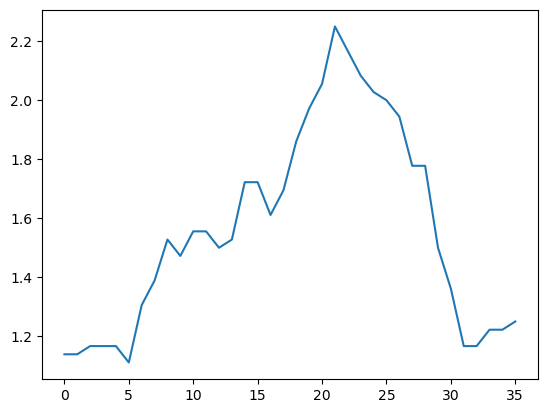

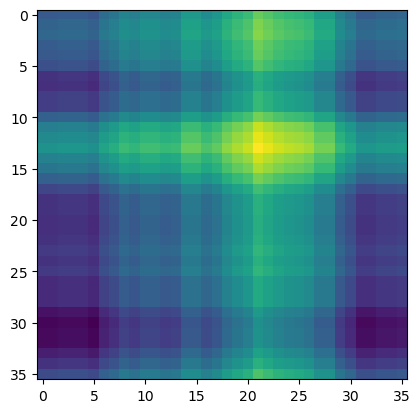

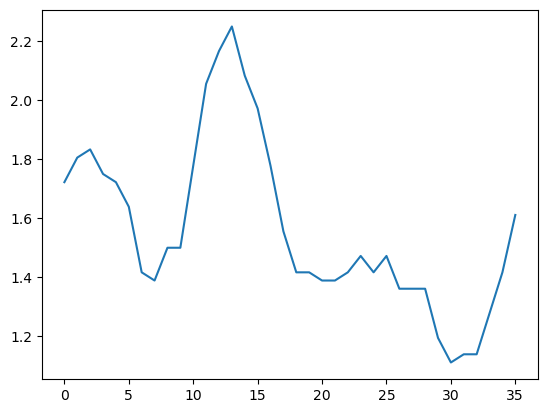

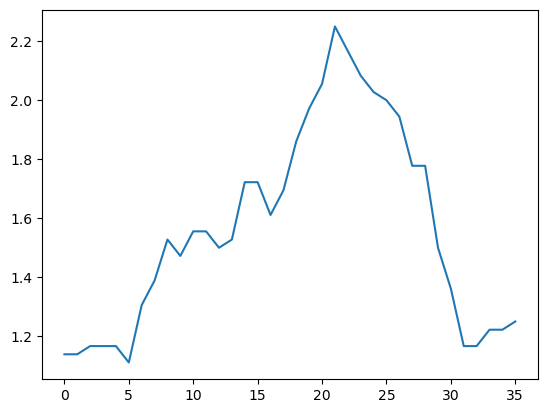

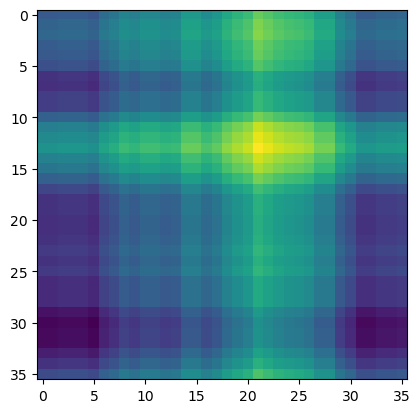

In [5]:
for _, space in subject_space:
    c_marg = np.mean(reward_map, axis=1)[:, None]
    s_marg = np.mean(reward_map, axis=0)[:, None]
    idp_space = (c_marg + s_marg.T) / 2
    fig1, ax1 = plt.subplots(1)
    fig2, ax2 = plt.subplots(1)
    fig3, ax3 = plt.subplots(1)
    ax1.plot(c_marg)
    ax2.plot(s_marg)
    ax3.imshow(idp_space)
    fig1.savefig("../saved_data/out_rl_figs/color_marginal_" + space + ".svg")
    fig2.savefig("../saved_data/out_rl_figs/shape_marginal_" + space + ".svg")
    fig3.savefig("../saved_data/out_rl_figs/independent_map_" + space + ".svg")

In [103]:
# load all trial data
data = []
for S, _ in subject_space:
    subject_trials = "../saved_data/all_" + S + ".csv"
    d = pd.read_csv(subject_trials, sep="\t").iloc[:400000]
    data.append(d)

In [104]:
def _get_choices_rewards(trial_data):
    """
    <n, 4, 2> choices on range (0, s_real | c_real)
    """
    raw_choices = trial_data[["c1", "s1", "c2", "s2", "c3", "s3", "c4", "s4"]].to_numpy().reshape((-1, 4, 2))
    time_stamps = trial_data[["time_delta_sec"]].to_numpy().flatten()
    time_stamps = time_stamps - np.concatenate(
        [time_stamps[0][None], time_stamps[:-1]])  # every time stamp minus the one before
    time_stamps = time_stamps / (60 * 60)  # convert from seconds to hours.
    raw_choices = raw_choices
    choice_idx = trial_data.choice_idx.to_numpy()
    reward = trial_data.reward.to_numpy()
    return raw_choices.astype(int), choice_idx, reward, time_stamps

choices = []
choice_idxs = []
rewards = []
time_stamps = []
for d in data:
    o, ci, r, dt = _get_choices_rewards(d)
    choices.append(o)
    choice_idxs.append(ci)
    rewards.append(r)
    time_stamps.append(dt)

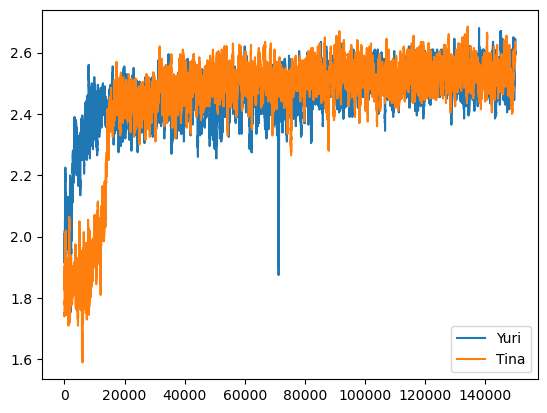

In [80]:
times = np.cumsum(np.stack(time_stamps), axis=1)
fig, ax = plt.subplots()
for i, r in enumerate(rewards):
    fr = uniform_filter1d(r.astype(float).flatten(), 200)
    ax.plot(fr, label=SUBJECTS[i])
plt.legend()
fig.savefig("../saved_data/out_rl_figs/reward_history.svg")

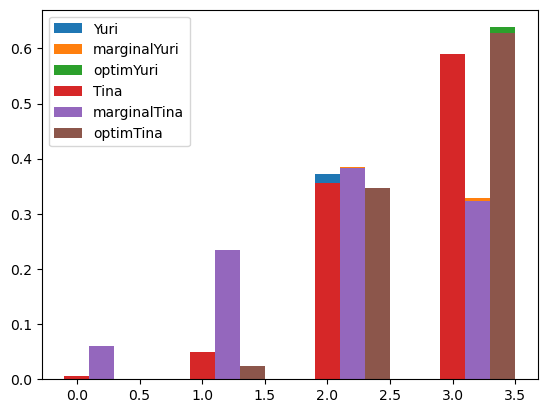

In [97]:
# plateu performance vs marginal integrator and optimal
range = 10000
fig, axs = plt.subplots(1)
for i, (s, space) in enumerate(subject_space):
    reward_map = pd.read_csv("../../data/reward_space_" + space + ".csv").iloc[:, 0].values.reshape((36, 36)).T
    c_marg = np.mean(reward_map, axis=1)[:, None]
    s_marg = np.mean(reward_map, axis=0)[:, None]
    idp_space = (c_marg + s_marg.T) / 2
    op = choices[i][-range:]
    stims = op.reshape((-1, 2))
    cidx = choice_idxs[i][-range:]
    true_vals = reward_map[stims[:, 0], stims[:, 1]].reshape(op.shape[:2])
    # get optimal reward freqs
    _, opt_freqs = np.unique(true_vals.max(axis=1), return_counts=True)
    opt_freqs = opt_freqs / np.sum(opt_freqs)
    # get marginal reward estimate and actual reward
    marginal_exp_vals = idp_space[stims[:, 0], stims[:, 1]].reshape(op.shape[:2])
    marginal_cidx = np.argmax(marginal_exp_vals, axis=1)
    marginal_choices = op[np.arange(len(marginal_cidx)), marginal_cidx]
    marginal_true_vals = reward_map[marginal_choices[:, 0], marginal_choices[:, 1]]
    _, marg_freqs = np.unique(marginal_true_vals, return_counts=True)
    marg_freqs = marg_freqs / np.sum(marg_freqs)
    # get monkey choice reward frequencies
    monk_choices = op[np.arange(len(cidx)), cidx]
    monk_true_vals = reward_map[monk_choices[:, 0], monk_choices[:, 1]]
    _, monk_freqs = np.unique(monk_true_vals, return_counts=True)
    monk_freqs = monk_freqs / np.sum(monk_freqs)
    axs.bar(np.arange(4), height=monk_freqs, width=.2, label=s)
    axs.bar(np.arange(4) + .2, height=marg_freqs, width=.2, label="marginal" + s)
    axs.bar(np.arange(4) + .4, height=opt_freqs, width=.2, label="optim" + s)
    # get optimal expected reward
fig.savefig("../saved_data/out_rl_figs/preform_vs_bli.svg")
plt.legend()
plt.show()

<BarContainer object of 4 artists>

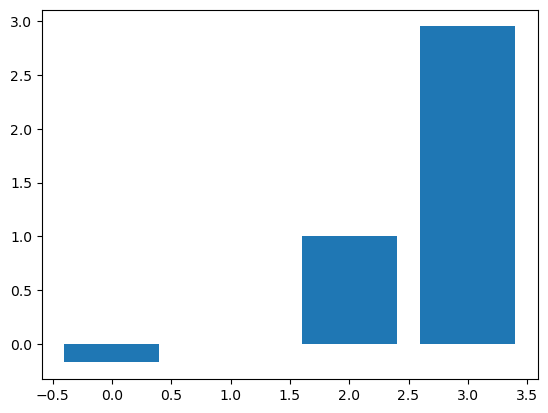

In [110]:
# get combined subjectiove value map. 
range = 300000
monk_val_map = np.zeros((36, 36))
for i, s in enumerate(SUBJECTS):
    fmap = pd.read_csv("../../data/freq_space_" + space + ".csv").iloc[:, 0].values.reshape((36, 36)).T
    op = choices[i][-range:]
    stims = op.reshape((-1, 2))
    cidx = choice_idxs[i][-range:]
    monk_choices = op[np.arange(len(cidx)), cidx]
    for c in monk_choices:
        monk_val_map[c[0], c[1]] += 1
#plt.imshow()
monk_val_map /= fmap
# estimate reward values
unnorm_subj_rval = np.zeros(4)
for r in [0, 1, 2, 3]:
    unnorm_subj_rval[r] = np.mean(monk_val_map[reward_map==r])
# normalize reward
norm_rval = (unnorm_subj_rval - unnorm_subj_rval[1]) 
norm_rval /= norm_rval[2]
plt.bar(np.arange(4), height=norm_rval)